# SDSS Performance Comparison | Hollis McLeod, Elijah Johnson

The following code is the product of the combined efforts of Hollis McLeod and Elijah Johnson for the term project in the Fall 2025 Section #22904 of AST4930 - Special Topics: Machine Learning at the University of Florida. This code is not for viewing, use, analysis, or any other purposes not in compliance with the [University of Florida Honor Code](https://policy.ufl.edu/regulation/4-040/). Violations will be reported accordingly.

## Overview

This Jupyter notebook defines a method for reading, processing, training machine learning models on, and visualizing results for [SDSS data](https://skyserver.sdss.org/dr19/SearchTools/sql) of the following form.

500,000 rows were downloaded as *SDSS.csv*, although 100,000 rows are planned for use. If computational power permits, however, more will be used for increased rigor of analysis.

**Fields**:
- Identification and standard features of astronomical objects (not used for training)
  - `objid`
  - `ra`
  - `dec`
  - `specobjid`
- Magnitudes
  - `u`
  - `g`
  - `r`
  - `i`
  - `z`
- Color indices (calculated)
  - `u-g`
  - `g-r`
  - `r-i`
  - `i-z`
- `redshift`
- `class`
  - "GALAXY"
  - "QSO" (shorthand for quasar)
  - "STAR"

**SQL Code**:
```
SELECT TOP 500000
p.objid,p.ra,p.dec,p.u,p.g,p.r,p.i,p.z,
p.u-p.g as 'u-g', p.g-p.r as 'g-r', p.r-p.i as 'r-i', p.i-p.z as 'i-z',
s.specobjid, s.class, s.z as redshift
FROM PhotoObj AS p
JOIN SpecObj AS s ON s.bestobjid = p.objid
WHERE s.class IN ('GALAXY', 'QSO', 'STAR')
```

## Setup

### Install and Import Packages

In [160]:
# Install if not already installed.
# %pip install pandas
# %pip install numpy
# %pip install scipy
# %pip install matplotlib
# %pip install scikit-learn

In [219]:
# Consolidate all imports together for easy use.
import pandas as pd

import numpy as np

from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.svm import SVC, SVR
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.inspection import permutation_importance
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# For capturing subprocess output with GridSearchCV parallelization
from joblib import parallel_backend # TODO: currently unused!

import matplotlib.pyplot as plt

### Define Paths and Constants

In [220]:
# These paths are stored in a dictionary for easy access and non-verbosity
paths = {
    # location of SDSS data
    'data': './data/SDSS.csv',

    # base directories for saved graphs, charts, models
    'supervised_products': './products/supervised/',
    'unsupervised_products': './products/unsupervised/',

    # additional pathing for specific products
    'graphs': 'graphs/',
    'charts': 'charts/',
    'models': 'models/'
}

In [221]:
# The number of rows to be used with the data
NROWS = 100000

# The column names of the features and the class from the dataset
FEATURES = ['u', 'g', 'r', 'i', 'z', 'u-g', 'g-r', 'r-i', 'i-z', 'redshift']
CLASS = 'class'

# The number of CPU cores we want to use for training, when possible. -1 means all that are available.
N_JOBS = -1

### Import Data and Perform Preliminary Processing

In [222]:
data = pd.read_csv(paths['data'], nrows=NROWS)
data

,objid,ra,dec,u,g,r,i,z,u-g,g-r,r-i,i-z,specobjid,class,redshift
0,1237668705156530825,263.370025,7.223793,18.08503,16.13823,15.28424,14.93009,14.71180,1.946796,0.853986,0.354156,0.218284,3149144865661544448,STAR,-0.000976
1,1237668705693467044,263.664289,7.488496,20.73099,19.08960,18.26207,17.86547,17.68044,1.641390,0.827530,0.396591,0.185038,3172787664193611776,GALAXY,0.735104
2,1237668705693468328,263.711809,7.529318,19.98693,18.40730,17.72147,17.44062,17.31446,1.579628,0.685833,0.280849,0.126162,3149149538585962496,STAR,-0.000280
3,1237668571475018376,262.378986,6.996502,25.06067,19.90350,18.44531,17.69727,17.27005,5.157169,1.458197,0.748039,0.427219,3172843739286628352,STAR,-0.000059
4,1237671696061236496,263.684828,8.193936,20.79169,19.28190,18.61582,18.31616,18.15825,1.509792,0.666075,0.299660,0.157909,3172804431745935360,STAR,-0.000074
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
99995,1237666209239269489,255.838908,27.333566,18.55913,16.88940,16.21973,15.95857,15.83906,1.669731,0.669672,0.261165,0.119510,3161585838186326016,STAR,-0.000256
99996,1237662638523220956,240.927307,9.760700,23.87011,21.08361,20.28882,20.15691,20.16212,2.786507,0.794788,0.131912,-0.005213,5493271238775429120,QSO,3.426004
99997,1237651737930499236,239.576144,2.691617,23.77327,23.11989,21.43978,20.39449,19.64420,0.653383,1.680111,1.045284,0.750292,5411089616244856832,GALAXY,0.633541
99998,1237662303525143296,254.194683,26.466377,24.63793,21.74906,19.97466,18.97339,18.56893,2.888876,1.774393,1.001272,0.404459,4706452196270823424,GALAXY,0.496634


In [223]:
# Separate into X and Y
X = data[FEATURES].values
Y = data[CLASS]

CLASSES = np.unique(Y)

print(f'SHAPES:\n  -{X.shape}\n  -{Y.shape}')
print(f'CLASSES: {CLASSES}')

SHAPES:
  -(100000, 10)
  -(100000,)
CLASSES: ['GALAXY' 'QSO' 'STAR']


In [224]:
# Split into training and testing
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, random_state=0)

## Supervised Machine Learning

This section contains training, optimization, testing, and creation of products for the following supervised machine learning algorithms:

- k-Nearest Neighbors (kNN)
- Decision Tree (DT)
- Support Vector Machine Classifier (SVM-C)
- Random Forest Classifier (RF-C)
- Adaptive Boosting (AdaBoost) with Base DT

### Training Setup

Define parameter grids for each model for `cv=5`.

In [192]:
CV = 5
SCALER = StandardScaler()

Define functions to make it easier to produce parameter grids for each model, for experimentation and cleanliness.

In [225]:
# Produce a parameter grid for kNN
def param_grid_knn(n_neighbors=np.arange(10)+1, algos=['auto']):
    return {
        'n_neighbors': n_neighbors,
        'algorithm': algos
    }

In [265]:
# Produce a parameter grid for DT
def param_grid_dt(max_depth=np.arange(20)+1, criterion=['gini', 'entropy']):
    return {
        'max_depth': max_depth,
        'criterion': criterion
    }

In [227]:

# Produce a parameter grid for an SVM-C
def param_grid_svmc(C=np.logspace(-4, 4, num=5), gamma=np.logspace(-4, 4, num=5)):
    return {
        'C': C,
        'gamma': gamma
    }

In [228]:

# Produce a parameter grid for an RF-C
def param_grid_rfc(n_estimators=[100, 500, 1000, 5000, 10000]):
    return {
        'n_estimators': n_estimators
    }

In [229]:
# Produce a parameter grid for an AdaBoost Classifier with Base DT. 
def param_grid_ada_dt(n_estimators=[10, 50, 100, 200], learning_rate=[0.001, 0.01, 0.1, 1.0], max_depth=1, criterion='gini'):
    # Per Worksheet 5, we want a poor base estimator for AdaBoost, so we default to max_depth=1 and criterion='gini.
    return {
        'estimator__max_depth': max_depth,
        'estimator__criterion': criterion,
        'n_estimators': n_estimators,
        'learning_rate': learning_rate
    }

Define functions to create `Pipeline`s for each model, for experimentation and cleanliness.

In [269]:
# Produce a pipeline and parameter grid for kNN
def create_knn_for_grid_search(n_neighbors=np.arange(10)+1, algos=['auto']):
    pipe = Pipeline([
        ('scaler', SCALER), # kNN requires feature scaling!
        ('kNN', KNeighborsClassifier())
    ])

    param_grid = {
        'kNN__n_neighbors': n_neighbors,
        'kNN__algorithm': algos
    }

    return pipe, param_grid

In [270]:
# Produce a pipeline and parameter grid for DT
def create_dt_for_grid_search(max_depth=np.arange(20)+1, criterion=['gini', 'entropy']):
    pipe = Pipeline([
        ('DT', DecisionTreeClassifier(random_state=0))
    ])

    param_grid = {
        'DT__max_depth': max_depth,
        'DT__criterion': criterion
    }

    return pipe, param_grid

In [232]:
# Produce a pipeline and parameter grid for SVM-C
def create_svmc_for_grid_search(C=np.logspace(-4, 4, num=5), gamma=np.logspace(-4, 4, num=5)):
    pipe = Pipeline([
        ('scaler', SCALER), # SVM requires feature scaling!
        ('SVM', SVC(kernel='rbf', random_state=0))
    ])

    param_grid = {
        'SVM__C': C,
        'SVM__gamma': gamma
    }

    return pipe, param_grid

In [233]:
# Produce a pipeline and parameter grid for RF-C
def create_rfc_for_grid_search(n_estimators=[100, 500, 1000, 5000, 10000]):
    pipe = Pipeline([
        ('RF', RandomForestClassifier(oob_score=True, random_state=0))
    ])

    param_grid = {
        'RF__n_estimators': n_estimators
    }

    return pipe, param_grid

In [234]:
# Produce a pipeline and parameter grid for AdaBoost with Base DT.
def create_adaboost_for_grid_search(n_estimators=[10, 50, 100, 200], learning_rate=[0.001, 0.01, 0.1, 1.0], max_depth=1, criterion='gini'):
    # Per Worksheet 5, we want a poor base estimator for AdaBoost, so we default to max_depth=1 and criterion='gini.
    pipe = Pipeline([
        ('ADA', AdaBoostClassifier(
            random_state=0,
            estimator=DecisionTreeClassifier(
                max_depth=max_depth,
                criterion=criterion)))
    ])

    param_grid = {
        'ADA__n_estimators': n_estimators,
        'ADA__learning_rate': learning_rate
    }

    return pipe, param_grid

Define a function to train models.

In [278]:
# Train a grid search model on a pipeline and a parameter grid, printing the best results and returning the grid search.
def get_grid_search_results(pipe, param_grid, x_train=X_train, x_test=X_test, y_train=Y_train, y_test=Y_test, n_jobs=N_JOBS, cv=CV, r_t_s=True, verbose=3):
    grid_search = GridSearchCV(
        pipe,
        param_grid=param_grid,
        cv=cv,
        n_jobs=n_jobs,
        verbose=verbose,
        return_train_score=r_t_s
    )

    grid_search.fit(x_train, y_train)

    print(f'Best Model: {grid_search.best_estimator_}')
    print(f'Best Parameters: {grid_search.best_params_}')
    print(f'Test Score: {grid_search.score(x_test, y_test)}')
    print(f'Mean Fit Time: {np.mean(grid_search.cv_results_['mean_fit_time'])}s') #TODO: look into creating a way to track every single fit time?
    return grid_search

### Analysis Setup

#### General

In [273]:
# Helper function to extract the parameters of a model into a meaningful string for titles and filenames.
def get_model_and_feature_string_from_grid_search(gs, pipelined=True, model_name=None):
    feature_str = ''
    model = None
    match model_name:
        case 'kNN':
            model = gs.best_estimator_[1] if pipelined else gs.best_estimator_
            n_neighbors = gs.best_params_['kNN__n_neighbors' if pipelined else 'n_neighbors']
            algo = gs.best_params_['kNN__algorithm' if pipelined else 'algorithm']
            feature_str = f'(k={n_neighbors})(algorithm={algo})'
        case 'DT':
            model = gs.best_estimator_[0] if pipelined else gs.best_estimator_
            m_d = gs.best_params_['DT__max_depth' if pipelined else 'max_depth']
            crit = gs.best_params_['DT__criterion' if pipelined else 'criterion']
            feature_str = f'(max_depth={m_d})(criterion={crit})'
        case 'SVM-C':
            model = gs.best_estimator_[1] if pipelined else gs.best_estimator_
            c = gs.best_params_['SVM__C' if pipelined else 'C']
            gamma = gs.best_params_['SVM__gamma' if pipelined else 'gamma']
            feature_str = f'(C={c})(gamma={gamma})'
        case 'RF-C':
            model = gs.best_estimator_[0] if pipelined else gs.best_estimator_
            n_est = gs.best_params_['RF__n_estimators' if pipelined else 'n_estimators']
            feature_str = f'(n_estimators={n_est})'
        case 'AdaBoost':
            model = gs.best_estimator_[0] if pipelined else gs.best_estimator_
            n_est = gs.best_params_['ADA__n_estimators' if pipelined else 'n_estimators']
            learn_rate = gs.best_params_['ADA__learning_rate' if pipelined else 'learning_rate']
            feature_str = f'(n_estimators={n_est})(learning_rate={learn_rate})'
        case _:
            raise ValueError('The \'model_name\' parameter cannot be unspecified. Please set \'model_name\' equal to \'kNN\', \'DT\', \'SVM-C\', \'RF-C\', or \'AdaBoost\'.')
        
    return model, feature_str

In [249]:
# Make a plot of feature importance using code adapted from the module 3 worksheet.
def plot_feature_importances_from_supervised_grid_search(gs, model_name=None, pipelined=True, x_tr=X_train, x_te=X_test, y_tr=Y_train, y_te=Y_test, save=True, n_repeats=10):
    if model_name is None: raise ValueError('The \'model_name\' parameter cannot be unspecified. Please set \'model_name\' equal to \'kNN\', \'DT\', \'SVM-C\', \'RF-C\', or \'AdaBoost\'.')
    # Gather information about the model
    model, feature_str = get_model_and_feature_string_from_grid_search(gs, model_name=model_name, pipelined=pipelined)

    # Get actual feature importances
    model.fit(x_tr, y_tr)
    r = permutation_importance(model, x_te, y_te, n_repeats=n_repeats, random_state=0)

    n_features = len(FEATURES)
    plt.barh(np.arange(n_features), r.importances_mean, align='center')
    plt.yticks(np.arange(n_features), FEATURES)
    plt.xlabel('Feature Importance')
    plt.ylabel('Feature')
    plt.ylim(-1, n_features)
    plt.tight_layout()

    # Add a title and save the plot
    plt.title(f'{model_name} SDSS Feature Importances ' + feature_str)
    if save: plt.savefig(paths['supervised_products'] + paths['charts'] + f'{model_name}_Feature_Importance_' + feature_str + '.png')
    plt.show()


In [274]:
# Make a confusion matrix using the supervised grid_search's best estimator.
def confusion_matrix_from_pipeline_grid_search(gs, model_name=None, pipelined=True, x_te=X_test, y_te=Y_test, save=True):
    if model_name is None: raise ValueError('The \'model_name\' parameter cannot be unspecified. Please set \'model_name\' equal to \'kNN\', \'DT\', \'SVM-C\', \'RF-C\', or \'AdaBoost\'.')
    
    # Get information about the model
    model, feature_str = get_model_and_feature_string_from_grid_search(gs, model_name=model_name, pipelined=pipelined)

    cm = confusion_matrix(model.predict(x_te), y_te)

    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=CLASSES)
    disp.plot(cmap='Blues')
    disp.ax_.set_title(f'Confusion Matrix for {model_name}{feature_str}')
    disp.figure_.tight_layout()
    if save: disp.figure_.savefig(paths['supervised_products'] + paths['charts'] + f'{model_name}_Confusion_Matrix_' + feature_str + '.png')
    plt.show()

#### kNN

In [236]:
# Plot the mean squared error as a function of n_neighbors. Adapted from module 4 worksheet.
def plot_mse_knn(gs_knn, save=True):
    results = gs_knn.cv_results_['mean_test_score']
    n_neighbors = len(results)
    plt.scatter(np.arange(n_neighbors)+1, -results)
    plt.xlabel('n_neighbors')
    plt.ylabel('Mean Squared Error')
    plt.title(f'kNN MSE vs. n_neighbors={n_neighbors}')
    plt.xticks(np.arange(len(results) - 1) + 1)
    if save: plt.savefig(paths['supervised_products'] + paths['graphs'] + f'kNN_MSE_k={n_neighbors}.png')
    plt.show()

In [277]:
# SAMPLE
pipe_knn, pg_knn = create_knn_for_grid_search()
gs_knn = get_grid_search_results(pipe_knn, pg_knn)

Fitting 5 folds for each of 10 candidates, totalling 50 fits
Best Model: Pipeline(steps=[('scaler', StandardScaler()),
                ('kNN', KNeighborsClassifier(n_neighbors=np.int64(3)))])
Best Parameters: {'kNN__algorithm': 'auto', 'kNN__n_neighbors': np.int64(3)}
Test Score: 0.97464
Mean Fit Time: 0.37447307586669926s


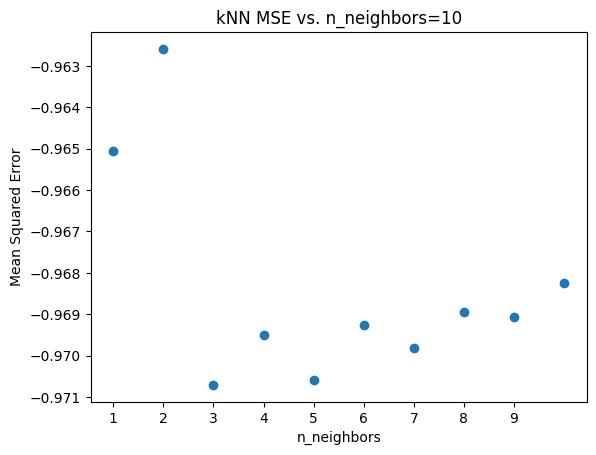

In [ ]:
# SAMPLE
plot_mse_knn(gs_knn)

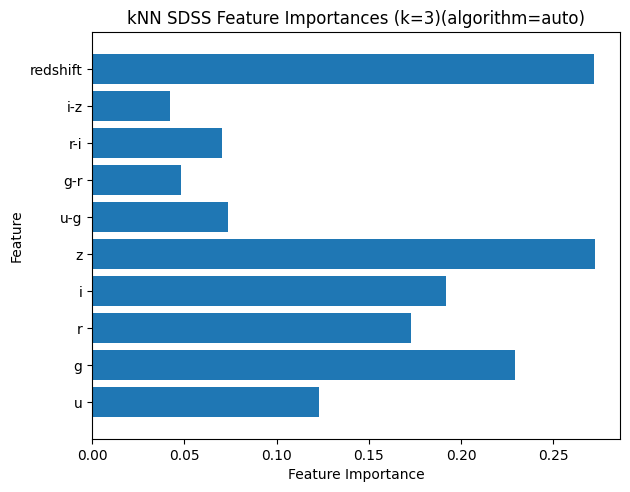

In [240]:
# SAMPLE
plot_feature_importances_from_supervised_grid_search(gs_knn, model_name='kNN')

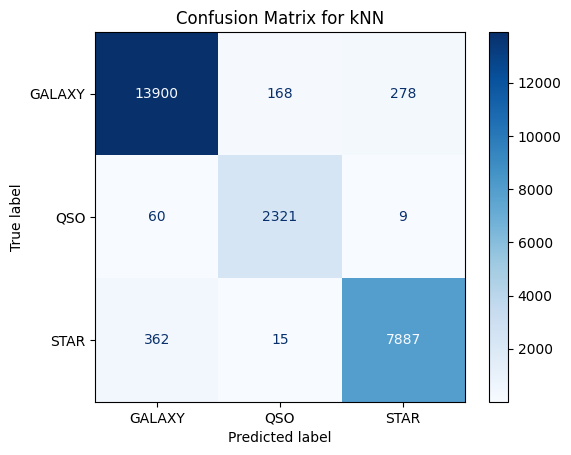

In [ ]:
# SAMPLE
confusion_matrix_from_pipeline_grid_search(gs_knn, model_name='kNN')

#### DT

In [256]:
# Print a visual tree of the best estimator
# TODO: may not be useful LOL
def plot_grid_search_DT(gs_dt, pipelined=True):
    plot_tree(gs_dt.best_estimator_[0] if pipelined else gs_dt.best_estimator_,
              feature_names=FEATURES,
              class_names=CLASSES)

In [275]:
# SAMPLE
pipe_dt, pg_dt = create_dt_for_grid_search()
gs_dt = get_grid_search_results(pipe_dt, pg_dt)

Fitting 5 folds for each of 40 candidates, totalling 200 fits
Best Model: Pipeline(steps=[('DT',
                 DecisionTreeClassifier(criterion='entropy',
                                        max_depth=np.int64(8),
                                        random_state=0))])
Best Parameters: {'DT__criterion': 'entropy', 'DT__max_depth': np.int64(8)}
Test Score: 0.98924
Mean Fit Time: 1.4392552423477174s


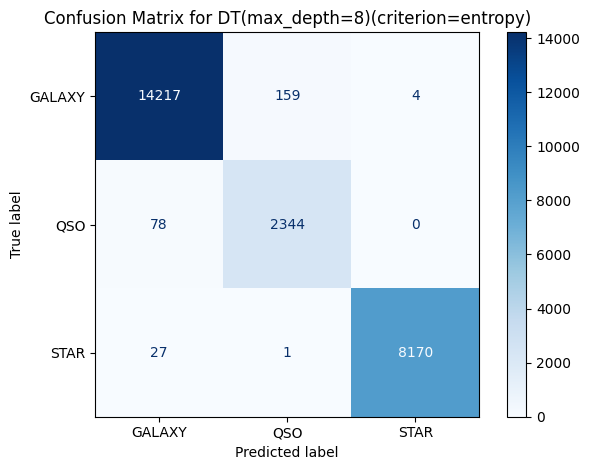

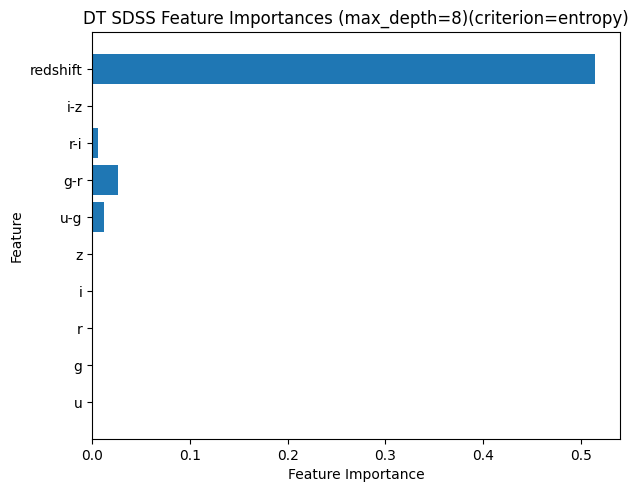

In [276]:
# SAMPLE
confusion_matrix_from_pipeline_grid_search(gs_dt, model_name='DT')
plot_feature_importances_from_supervised_grid_search(gs_dt, model_name='DT')

#### SVM Classifier

#### RF Classifier

#### AdaBoost Classifier with Base DT

## Unsupervised Machine Learning

This section contains training, optimization, testing, and creation of products for the following unsupervised machine learning algorithms:

- k-Means Clustering (k-means)
- Gaussian Mixture Model (GMM) Clustering
- Density-Based Spatial Clustering of Applications with Noise (DBSCAN)
- Neural Network (NN) with [XXXX] layers of [XXXX] nodes


### Training Setup